In [1]:
%env CUDA_VISIBLE_DEVICES=2
data_path = "gogs_test_data_real/raft_stereo1"

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import os
import matplotlib
import torch
from dexnet.grasp_model import HighResFCGQCNN as FCGQCNN
from matplotlib.patches import Circle
w = torch.load("/home/apgoldberg/Dex-Net-5.0/model_zoo/max_normal_normal_conversion.pth")

def load_zed_depth_folder(data_path, img_shape=(720, 1280)):
    num_files = len(os.listdir(os.path.join(data_path, "depth")))
    depth_ims = np.zeros((num_files, img_shape[0], img_shape[1], 1))
    for i in range(num_files):
        float_values = np.load(os.path.join(data_path, "depth", f"{i}.npy"))
        depth_ims[i] = float_values.reshape(img_shape[0], img_shape[1], 1).astype(np.float32)
    return depth_ims

def load_zed_rgb_folder(data_path, fname_append = "_l", img_shape=(720, 1280, 3)):
    num_files = len(os.listdir(os.path.join(data_path, "depth")))
    rgb_ims = np.zeros((num_files, img_shape[0], img_shape[1], 3))
    for i in range(num_files):
        float_values = plt.imread(os.path.join(data_path, "img", f"{i}{fname_append}.jpg"))
        rgb_ims[i] = float_values.reshape(img_shape[0], img_shape[1], 3).astype(np.float32)
    return rgb_ims 

def plot_arr(depth_ims, titles=None, max_imgs=None):
    cols = 4
    max_imgs = min(max_imgs, len(depth_ims)) if max_imgs is not None else len(depth_ims)
    fig, axes = plt.subplots(max_imgs // cols + 1, cols, figsize=(12, 16))
    for i, img in enumerate(depth_ims[:max_imgs]):
        axes[i//cols, i%cols].imshow(img)
        if titles is not None:
            axes[i//4, i%4].set_title(titles[i])
        
    for ax in axes.flatten():
        ax.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.show()

def plot_squares_with_numbers(arr):
    viridis = matplotlib.colormaps['viridis']
    color_div, color_add = np.nanmax(arr) - np.nanmin(arr), np.nanmin(arr)
    dim1, dim2 = arr.shape[0], arr.shape[1]
    fig, ax = plt.subplots(figsize=(32, 32))
    for i in range(dim1):
        for j in range(dim2):
            color = viridis((arr[i][j] - color_add) / color_div)
            ax.add_patch(plt.Rectangle((j, dim1 - i - 1), 1, 1, color=color))
            ax.text(j + 0.5, dim1 - i - 1 + 0.5, str(round(arr[i][j], 2)), ha='center', va='center')

    ax.set_xlim(0, dim2)
    ax.set_ylim(0, dim1)
    ax.axis('off')
    plt.show()


depth_ims = load_zed_depth_folder(data_path, img_shape=(704,1280))
rgb_ims = load_zed_rgb_folder(data_path, fname_append="_l", img_shape=(720, 1280))
model = FCGQCNN()
model.load_state_dict(w)
model.to("cuda")
model.eval()

/home/apgoldberg/miniconda3/envs/newdex/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/apgoldberg/miniconda3/envs/newdex/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


HighResFCGQCNN(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (lrn): LocalResponseNorm(2, alpha=2e-05, beta=0.75, k=1.0)
  (conv5): Conv2d(64, 1024, kernel_size=(16, 16), stride=(1, 1))
  (conv6): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
  (conv7): Conv2d(1024, 1, kernel_size=(1, 1), stride=(1, 1))
  (sigmoid): Sigmoid()
)

In [3]:
def img_nan_clean(input_img, table_value=.35):
    cleaned_array = input_img.copy()
    ### HARDCODED TABLE HEIGHT
    cleaned_array[np.isnan(cleaned_array) | (cleaned_array > 1) | (np.isclose(cleaned_array, 0, 0.1))] = table_value
    return cleaned_array

def preprocess_img(x, normal_crop="normal"):
    # kernel = np.ones((5,5), np.uint8)
    # x = cv2.dilate(x, kernel, iterations=1)
    # x = cv2.GaussianBlur(x, (5, 5), 5)
    if normal_crop == "self":
        x = (x - x.mean()) / x.std()
    elif normal_crop == "normal":
        normalizers = (
            0.59784445,
            # 0.00770147890625,
            .06873399
        )  # mean, std value for depth images (from analyze.py script)
        x = (x - normalizers[0]) / normalizers[1]
    else:
        x_crop = x[normal_crop[0]:normal_crop[1],normal_crop[2]:normal_crop[3]]
        x = (x - x_crop.mean()) / x_crop.std()
    x = x.squeeze()
    return x

In [30]:
def overlay_grasp_rgb(grasp, rgb):
    cmap = matplotlib.colormaps['rainbow']
    grasp_resized = cv2.resize(grasp, (rgb.shape[1], rgb.shape[0]))
    # grasp_mask = (grasp_resized >= .2)
    grasp_mask = (grasp_resized >= 0)
    rgb_overlayed = rgb.copy()
    rgb_overlayed[grasp_mask] = (
        cmap(grasp_resized)[:,:,:3][grasp_mask]
        # + .5*rgb[grasp_mask]
        )
    return rgb_overlayed.astype(np.uint8)

In [1]:
@torch.no_grad
def many_scales_inference(model, scales, input_img, rgb_img=None):
    model = model.cuda()
    grasp_outs = []
    for scale in scales:
        input_im = cv2.resize(input_img, (0,0), fx=scale, fy=scale)
        pad = 15
        input_im = cv2.copyMakeBorder(input_im, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
        input_im = torch.from_numpy(input_im.copy().astype(np.float32)).cuda().unsqueeze(0).unsqueeze(0)

        grasp_out = model(input_im).squeeze().cpu().numpy()
        print(grasp_out.max())
        if rgb_img is not None:
            grasp_out = overlay_grasp_rgb(grasp_out, rgb_img)
        else:
            max_coord = np.unravel_index(np.argmax(grasp_out), grasp_out.shape)
            grasp_out[max_coord[1]-2:max_coord[1]+2, max_coord[0]-2:max_coord[0]+2] = 1

        grasp_outs.append(grasp_out)

    
    plot_arr(grasp_outs, titles=scales)

@torch.no_grad
def many_z_adds_inference(model, zs, input_img):
    model = model.cuda()
    grasp_outs = []
    for z in zs:
        input_im = input_img + z
        input_im = torch.from_numpy(input_im.copy().astype(torch.float32)).cuda().unsqueeze(0).unsqueeze(0)

        grasp_out = model(input_im).squeeze().cpu().numpy()
        grasp_outs.append(grasp_out)
    
    plot_arr(grasp_outs, titles=zs)

NameError: name 'torch' is not defined

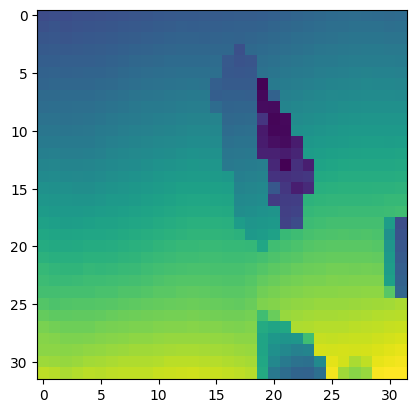

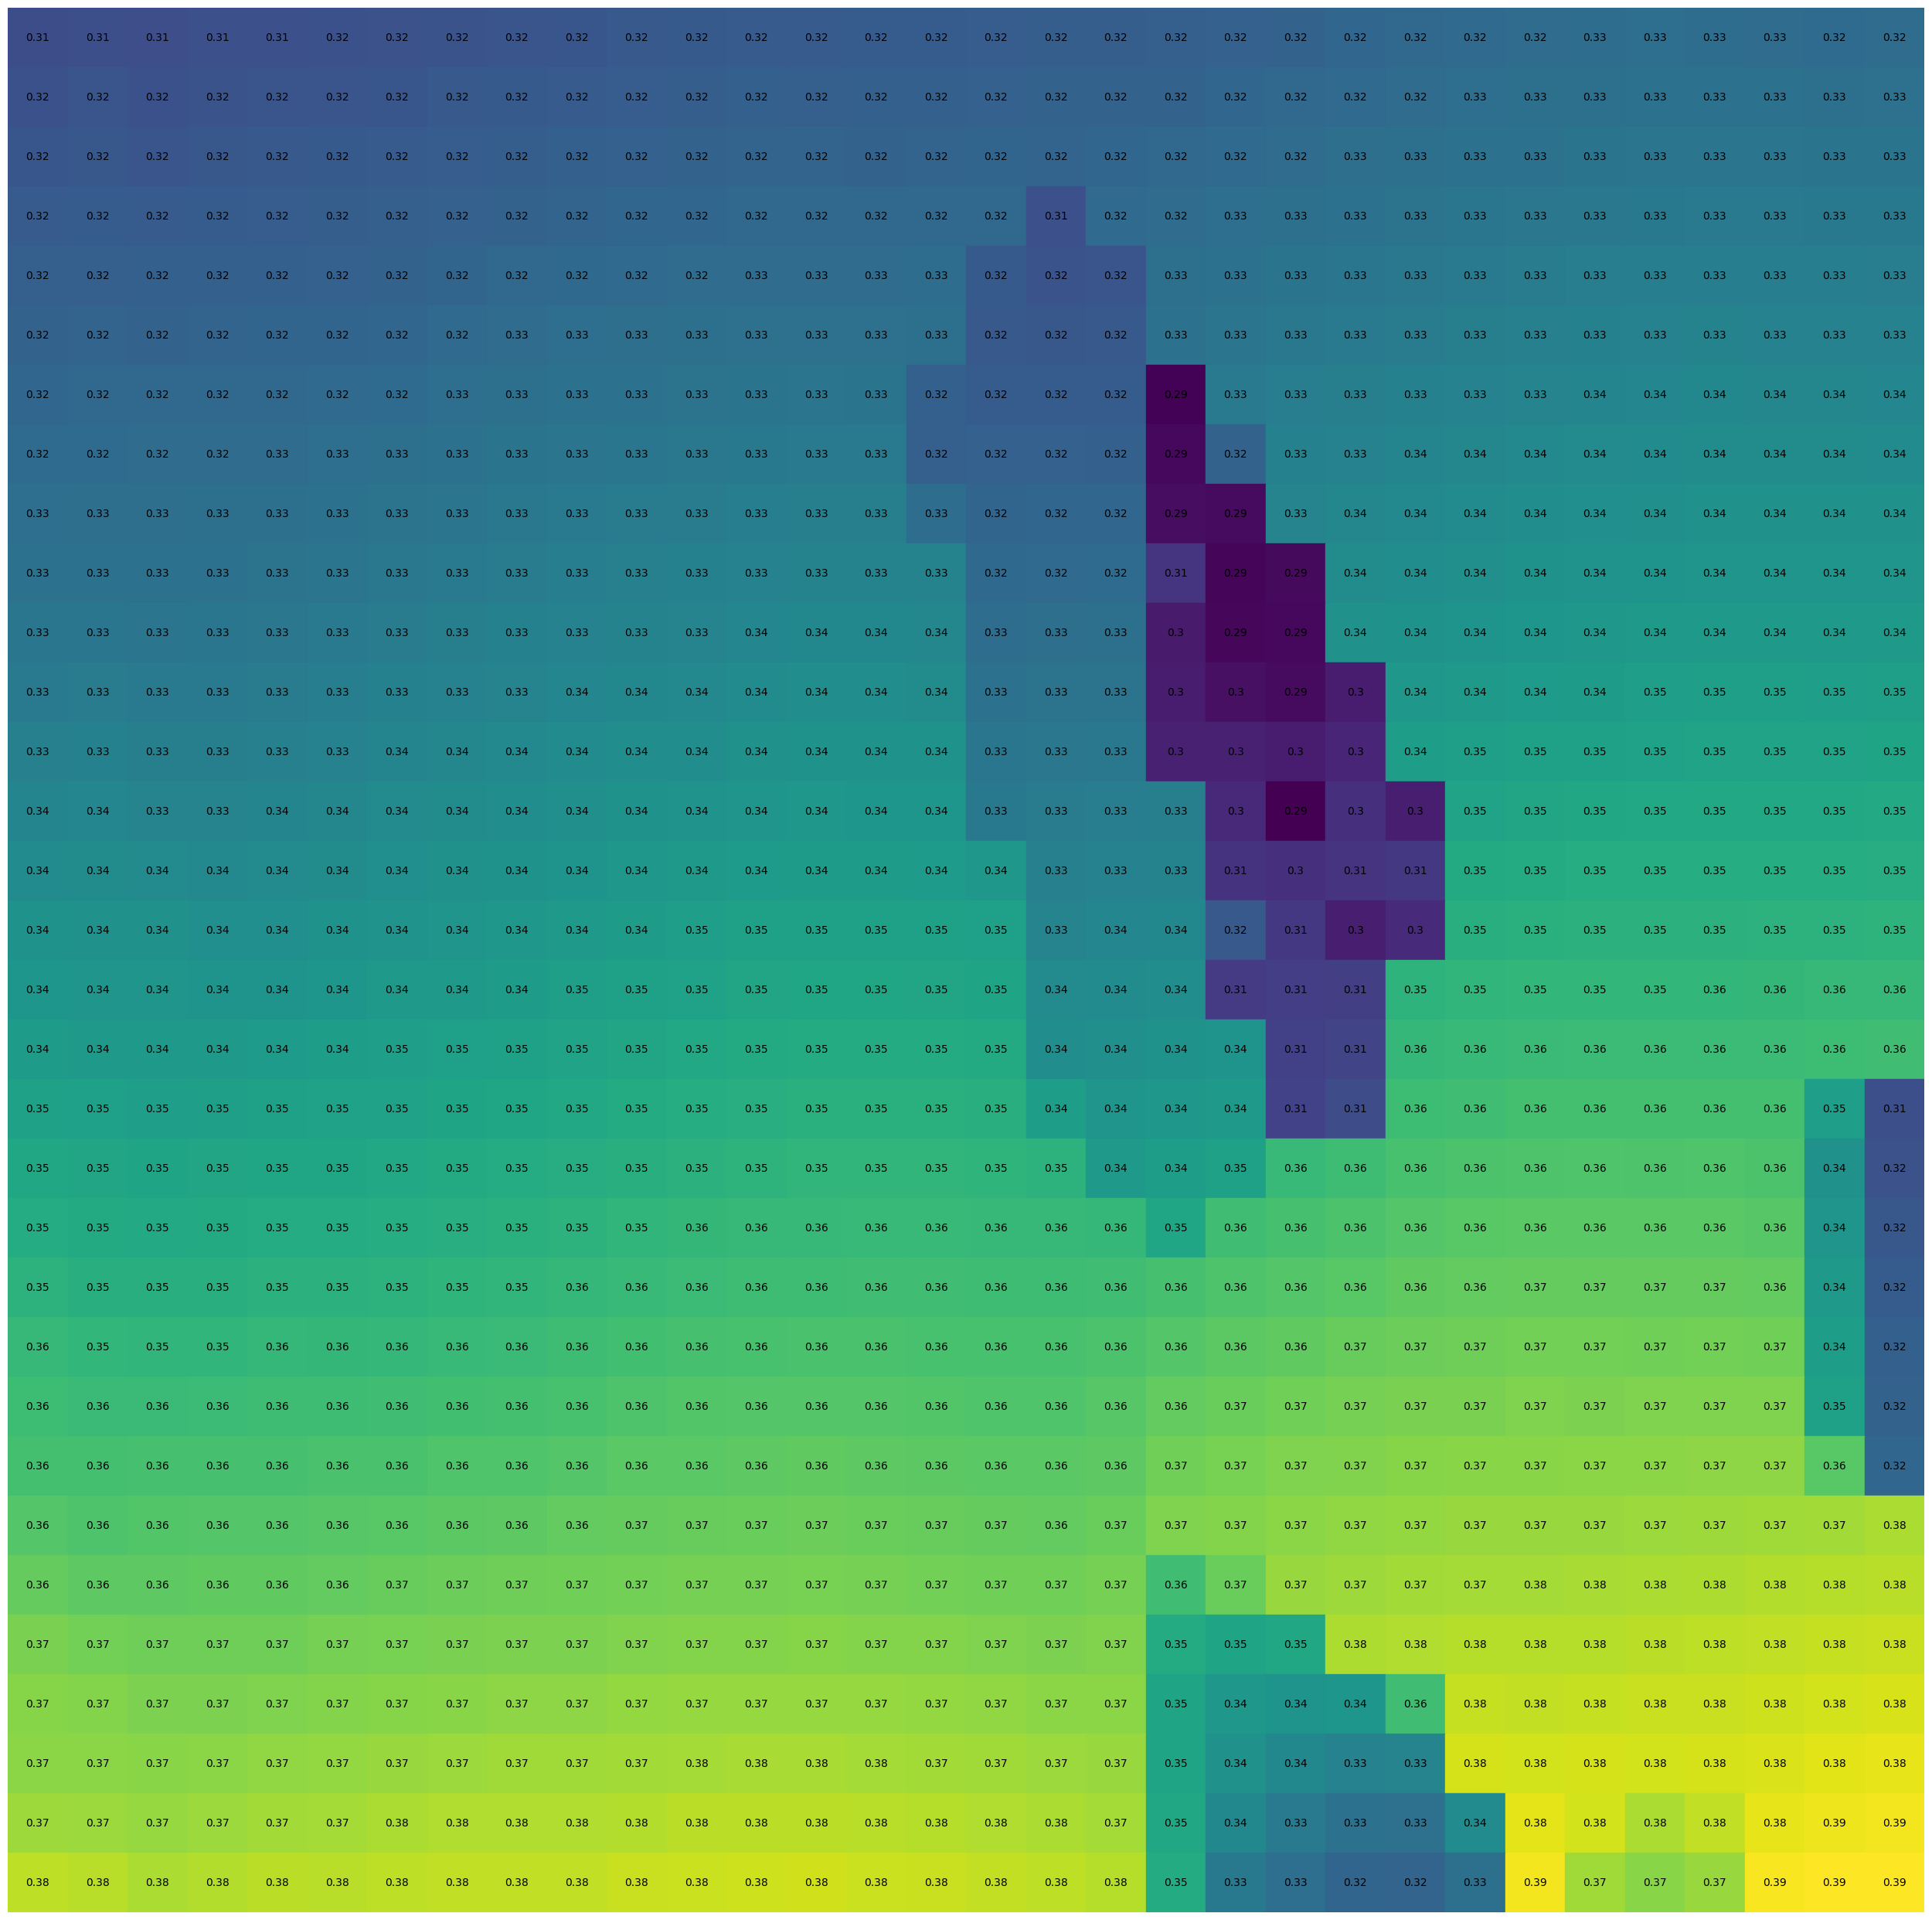

In [39]:
shrunk = (cv2.resize(depth_ims[1], (32, 32))).squeeze()
plt.imshow(shrunk)
plt.show()
plot_squares_with_numbers(shrunk)

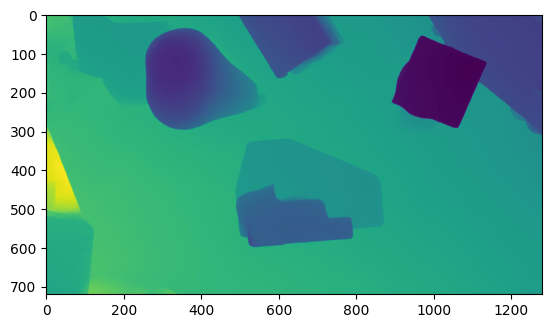

0.0033539918
0.010841615
0.015870024
0.040087726
0.049839437
0.0671876
0.069158316
0.0703152
0.075128905
0.075653285
0.087308615
0.09075253
0.09229558
0.093142554
0.084005415
0.092222586
0.09735247
0.08576968


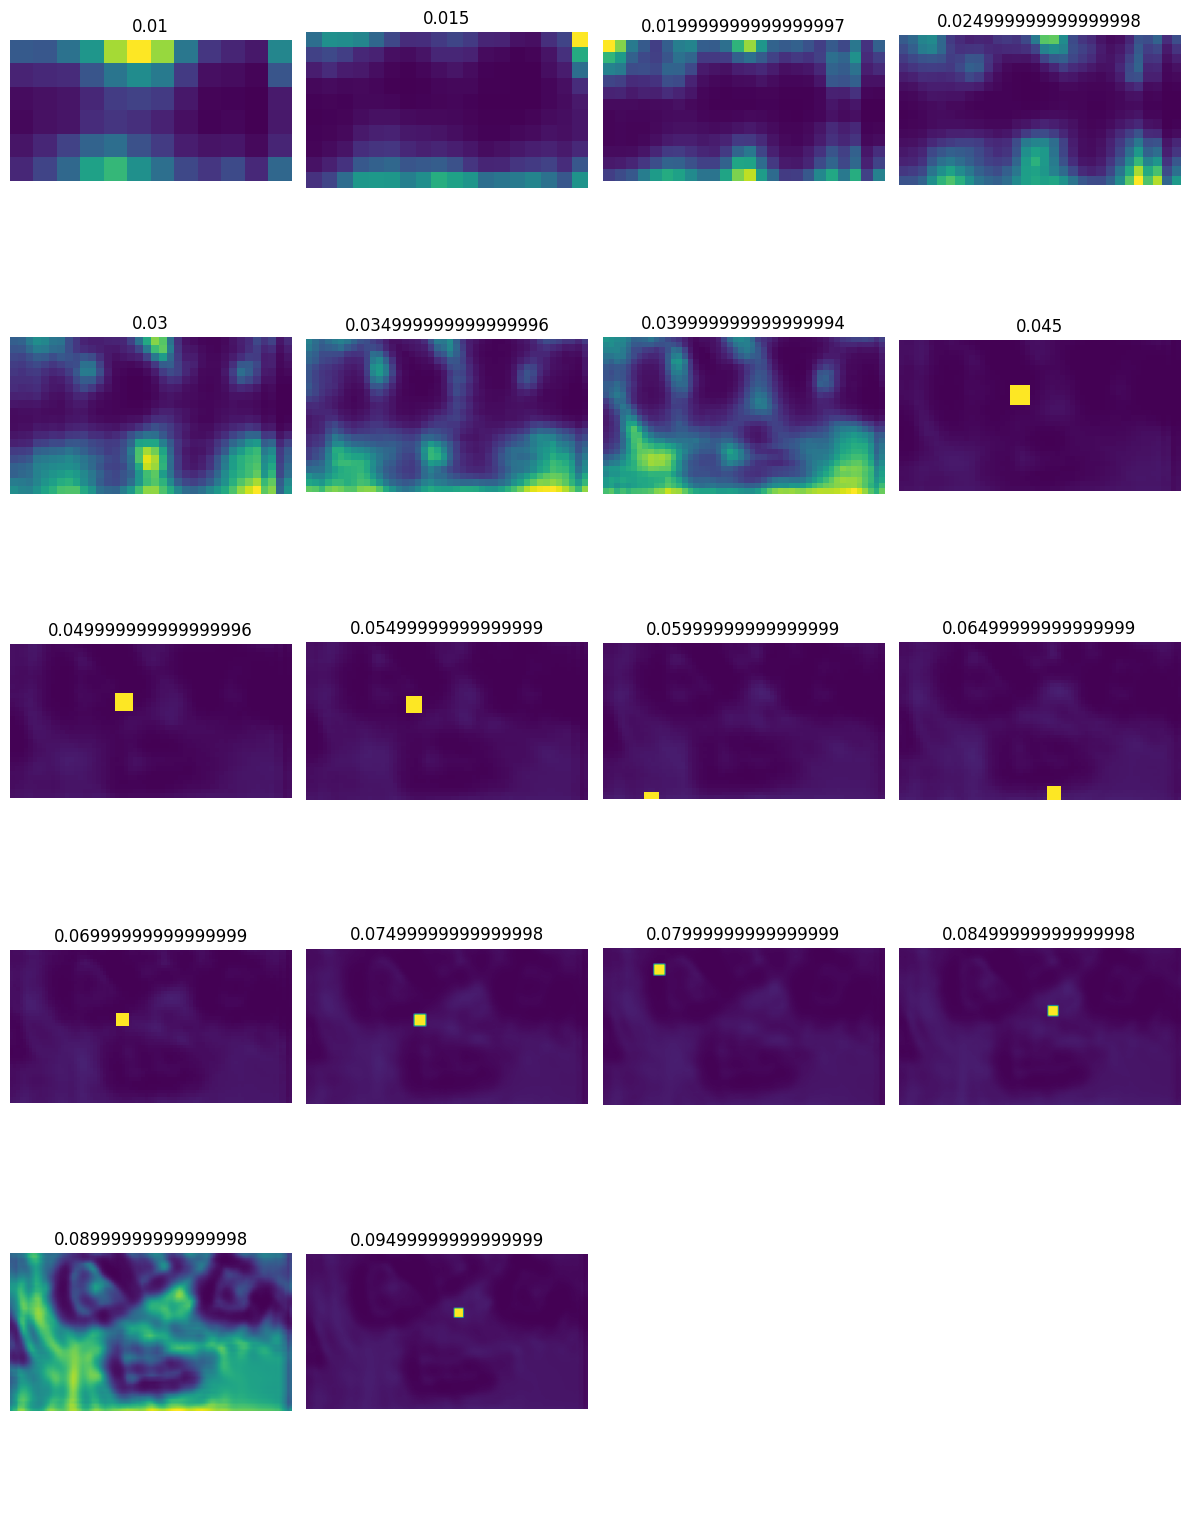

In [52]:
img_idx = 22
# processed_depth_input = preprocess_img(depth_ims[img_idx]) + .15
processed_depth_input = preprocess_img(
    np.load("/home/apgoldberg/Dex-Net-5.0/gogs_test_data_real/top_down_test/test_zed_depth2.npy")
    )
rgb_img = rgb_ims[img_idx]
plt.imshow(processed_depth_input)
plt.show()
# many_scales_inference(model, np.arange(.1, .6, .05), processed_depth_input, rgb_img = rgb_img)
many_scales_inference(model, np.arange(.01, .1, .005), processed_depth_input, rgb_img = None)